In [8]:
import numpy as np
import networkx as nx

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors

import sys
sys.path.append("../modules/")
import utils

from scipy.optimize import root_scalar

colors = ["w", "#F6FBE4", "#ECF6C9", "#E3F2AE", "#d9ed92", "#b5e48c", "#99d98c",
          "#76c893", "#52b69a", "#34a0a4", "#168aad", "#1a759f", "#1e6091", "#184e77"]
nodes = np.linspace(0, 1, len(colors))
cmap_PD = LinearSegmentedColormap.from_list("cmap_SR", list(zip(nodes, colors)))

def white_to_color(color, name = "cmap"):
    colors = ["w", color]
    nodes = np.linspace(0, 1, len(colors))
    return LinearSegmentedColormap.from_list("name", list(zip(nodes, colors)))

def add_transparency_to_colormap(original_cmap, minval=0.0, maxval=1.0, n=100):
    # Get the colors from the original colormap
    colors = original_cmap(np.linspace(minval, maxval, n))
    
    # Add an alpha channel based on the y values
    colors[:, 3] = np.linspace(0, 1, n)
    
    # Create the new colormap
    new_cmap = mcolors.LinearSegmentedColormap.from_list("transparent", colors)
    
    return new_cmap


In [13]:
def generate_RGG(N, d, seed, plot = False, shift = False):
    np.random.seed(seed)
    pos_x = np.random.uniform(0, 1, N)
    pos_y = np.random.uniform(0, 1, N)

    if shift:
        pos_y[73] += 0.037
        pos_y[33] += 0.037
        pos_y[68] += 0.037
        pos_y[8] += 0.037
        pos_y[37] -= 0.08

    pos = dict(zip(range(N), zip(pos_x, pos_y)))

    RGG_net = nx.random_geometric_graph(N, d, pos = pos)

    pos_mat = np.array(list(pos.values()))
    dist_mat = utils.euclidean_distance_matrix(pos_mat)

    mindistance = np.min(dist_mat[dist_mat > 0])
    for (u, v) in RGG_net.edges():
        RGG_net[u][v]['weight'] = mindistance/dist_mat[u, v]

    if plot:
        plt.figure(figsize = (6, 6))
        nx.draw(RGG_net, pos = pos, node_size = 100, node_color = 'k', width = 0.5, edge_color = 'k')
        plt.show()

    return RGG_net, pos, dist_mat

def ricker_wavelet(x, p1, p2, m = 3):
    return (1 - (m*x)**2/p1**2)*np.exp(-(m*x)**2/(2*p2**2))

def corrlen_eqn(L, p1, p2, m):
    return ricker_wavelet(L, p1, p2, m) - 1/np.exp(1)



# Figure 4

In [10]:
p1 = 1.3
mu = 1
N = 100
Nrep = 500
S = 5
rhostat_highcorr_RGG = np.load(f"../data/RGG_OCN/rhostat_RGG_highcorr_mu{mu}_p1{p1}.npy")
rhostat_lowcorr_RGG = np.load(f"../data/RGG_OCN/rhostat_RGG_lowcorr_mu{mu}_p1{p1}.npy")

mu = 0.5
rhotot_RGG = np.load(f"../data/RGG_OCN/rhostat_RGG_N{N}_S{S}_Nrep{Nrep}_p1{p1}_mu{mu}.npy")
p2_array = np.load(f"../data/RGG_OCN/p2array_RGG_N{N}_S{S}_Nrep{Nrep}_p1{p1}_mu{mu}.npy")

p1 = 5
mu = 1
rhostat_highcorr_OCN = np.load(f"../data/RGG_OCN/rhostat_OCN_highcorr_mu{mu}_p1{p1}.npy")
rhostat_lowcorr_OCN = np.load(f"../data/RGG_OCN/rhostat_OCN_lowcorr_mu{mu}_p1{p1}.npy")

In [14]:
loc_highcorr_RGG = np.mean(rhostat_highcorr_RGG**4, axis = 1)/np.mean(rhostat_highcorr_RGG**2, axis = 1)**2
loc_lowcorr_RGG = np.mean(rhostat_lowcorr_RGG**4, axis = 1)/np.mean(rhostat_lowcorr_RGG**2, axis = 1)**2

loc_highcorr_OCN = np.mean(rhostat_highcorr_OCN**4, axis = 1)/np.mean(rhostat_highcorr_OCN**2, axis = 1)**2
loc_lowcorr_OCN = np.mean(rhostat_lowcorr_OCN**4, axis = 1)/np.mean(rhostat_lowcorr_OCN**2, axis = 1)**2

adj_OCN = np.load("../data/RGG_OCN/adj_OCN.npy")
pos_OCN = np.load("../data/RGG_OCN/pos_OCN.npy")
Zmat_OCN = np.load("../data/RGG_OCN/Zmat_OCN.npy")
Areas_OCN = np.load("../data/RGG_OCN/Areas_OCN.npy")

RGG_net, pos, dist_mat = generate_RGG(N, d = 0.17, seed = 12, plot = False, shift = True)
OCN_net = nx.from_numpy_array(adj_OCN)

edge_ordering = np.array(OCN_net.edges())
ordered_areas = np.zeros(len(edge_ordering))
nodes_OCN = np.array(list(OCN_net.nodes()))

for i, (u, v) in enumerate(edge_ordering):
    ordered_areas[i] = Areas_OCN[nodes_OCN == u]

normed_areas = ordered_areas/np.max(ordered_areas)

clen_array_RGG = np.zeros_like(p2_array)
m = 3

for i, p2 in enumerate(p2_array):
    clen_array_RGG[i] = root_scalar(corrlen_eqn, args = (p1, p2, m), bracket = [0, 10]).root/np.max(dist_mat)


/var/folders/rp/4969vws91431vgg3v1nxd3bw0000gp/T/ipykernel_22441/3715280214.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ordered_areas[i] = Areas_OCN[nodes_OCN == u]


In [15]:
colors = ['#3d0066', '#40916c', '#0077b6', '#fcb75d', '#a4161a']
cmaps = [white_to_color(c) for c in colors]

# RGG

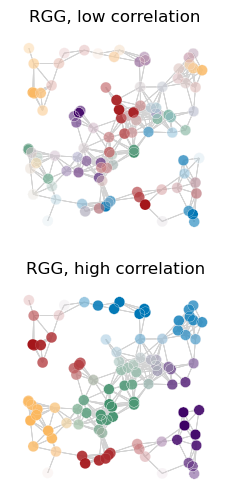

In [16]:
fig,axes = plt.subplots(2,1,figsize=(10,6))
for ax, rhostat in zip(axes, [rhostat_lowcorr_RGG, rhostat_highcorr_RGG]):
    ax.axis('off')
    ax.set_aspect('equal')
    for alpha in range(S):
        nx.draw_networkx_edges(RGG_net, pos = pos, width = 0.5, edge_color = 'lightgray', ax = ax, alpha = 0.8)
        nx.draw_networkx_nodes(RGG_net, pos = pos,  node_color = rhostat[alpha], ax = ax,
                               cmap = add_transparency_to_colormap(cmaps[alpha], minval = 0.1, maxval = 1), vmin = 0,
                               edgecolors='w', linewidths=0.08,
                               node_size = 60)
axes[0].set_title("RGG, low correlation")
axes[1].set_title("RGG, high correlation")
plt.show()


# OCN

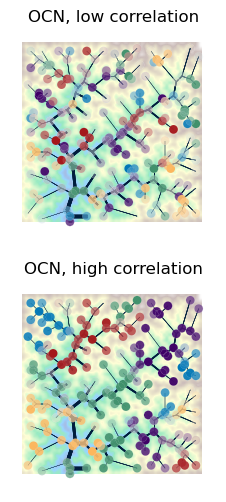

In [17]:
fig,axes = plt.subplots(2,1,figsize=(10,6))

for ax, rhostat in zip(axes, [rhostat_lowcorr_OCN, rhostat_highcorr_OCN]):
    ax.axis('off')
    ax.set_aspect('equal')
    ax.imshow(Zmat_OCN.T, cmap = "terrain", alpha = 0.4, interpolation = 'gaussian')
    for alpha in range(S):
        nx.draw_networkx_edges(OCN_net, pos = pos_OCN, width = 2.5*normed_areas**0.5, edge_color = '#001d3d', ax = ax, alpha = 0.8)
        nx.draw_networkx_nodes(OCN_net, pos = pos_OCN, node_size = 40, node_color = rhostat[alpha], ax = ax,
                               cmap = add_transparency_to_colormap(cmaps[alpha], minval = 0.1, maxval = 1), vmin = 0,
                               edgecolors='w', linewidths=0.02)
        
axes[0].set_title("OCN, low correlation")
axes[1].set_title("OCN, high correlation")
plt.show()

# Correlation vs population

Text(0.5, 0, '$d_{\\rm corr} / d_{\\rm max}$')

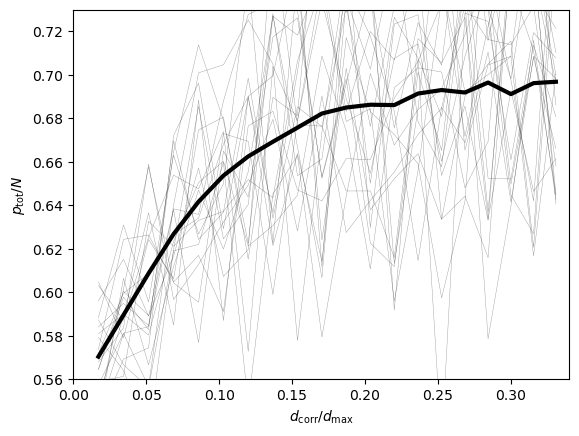

In [18]:
for idx_rep in range(20):
    plt.plot(clen_array_RGG, rhotot_RGG[idx_rep]/N, 'k', alpha = 0.4, lw = 0.3,zorder=-1)

plt.plot(clen_array_RGG, np.mean(rhotot_RGG, axis = 0)/N, 'k', lw = 3)
plt.ylim(0.56, 0.73)

plt.xlim(0, 0.34)
plt.ylabel(r"$p_{\rm tot}/N$")
plt.xlabel(r"$d_{\rm corr} / d_{\rm max}$")